# Transformations

This notebook explores spatial transformations or geometric operations applicable to 3D pointclouds. These transformations alter the position, orientation, and shape of objects in space. While a comprehensive mathematical treatment is beyond the scope of this notebook, it focuses on the most commonly used transformations in pointcloud processing: translations, rotations, reflections, and scaling. These transformations can be applied individually or in combination to achieve the desired manipulation of pointclouds.

Transformations can be classified based on the properties they preserve. Rigid motions, including translations, rotations, and reflections, maintain distances and angles between points, preserving the overall shape and size of the pointcloud. These are essential for tasks requiring geometric integrity, such as aligning pointclouds from different viewpoints. Affine transformations, which include rigid motions plus scaling and shearing, do not preserve distances and angles but maintain parallelism and ratios of distances along parallel lines. These are useful for resizing or reshaping the pointcloud.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt

# Load our bunny pointcloud
points = np.loadtxt("./data/stanford_bunny_simple.xyz")

## Translations

A translation moves every point of the pointcloud in the same direction.

In practice, a constant vector $t$ is simply added to each point of the pointcloud: 
\begin{equation*}
p' = p + t
\end{equation*}
Thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

A translation may be used to "center" a pointcloud, for example to make it roughly coincide with the origin of the coordinate system or with another pointcloud. This allows to introduce the notion of centroid (or center of mass if all points are weighted equally), which is the mean position of all the points of the pointcloud. This notion is widely used in pointcloud processing algorithms.

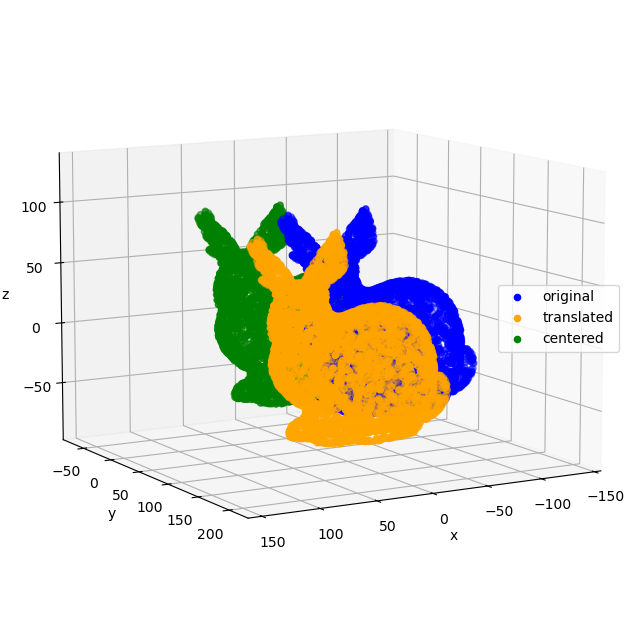

In [2]:
# Translated points
translation = np.array([50., 40., -10.])
translated_points = points + translation
# Centered points
centroid = points.mean(axis=0)
centered_points = points - centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(translated_points[:, 0], translated_points[:, 1], translated_points[:, 2],
           c='orange', label="translated")
ax.scatter(centered_points[:, 0], centered_points[:, 1], centered_points[:, 2],
           c='green', label="centered")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

## Rotations

**A rotation moves every point of the pointcloud around a certain axis and by a certain angle** (called $\theta$ here).

A rotation is said to be *elemental* (or *basic*) when considering one of the axes of the main coordinate system (i.e., $x$, $y$, and $z$). Rotation matrices around each axis are then given below. A rotation around the $x$ axis leave the first coordinate of each point unchanged, and so on.

\begin{equation*}
R_{x}(\theta_x) = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos\theta_x & -\sin\theta_x \\
0 & \sin\theta_x & \cos\theta_x
\end{pmatrix}
\quad
R_{y}(\theta_y) = 
\begin{pmatrix}
\cos\theta_y & 0 & \sin\theta_y \\
0 & 1 & 0 \\
-\sin\theta_y & 0 & \cos\theta_y
\end{pmatrix}
\quad
R_{z}(\theta_z) = 
\begin{pmatrix}
\cos\theta_z & -\sin\theta_z & 0 \\
\sin\theta_z & \cos\theta_z & 0 \\
0 & 0 & 1 
\end{pmatrix}
\end{equation*}

These rotations are counter-clockwise when the rotation axis is directed towards the observer (if the three-dimensional space is oriented according to the usual conventions, see the right-hand rule). Note that these rotations occur around the origin of the main coordinate system.

In practice, matrix multiplication is used to rotate each point of the pointcloud (do not forget that some attributes such as normals must also be rotated as well!). Due to the initial *row-wise* listing of points, some transpose operations are however necessary to keep dimensions consistent: 
\begin{equation*}
p' = (R(\theta).p^{T})^{T}
\end{equation*}
Again, thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

Some extra steps are necessary if a *local* coordinate system were to be considered. For example, for an "in-place" rotation, around the pointcloud center of mass (without any change in the axes direction), a simple solution consists in centering the pointcloud first, applying the rotation, and then moving the pointcloud around its original centroid.


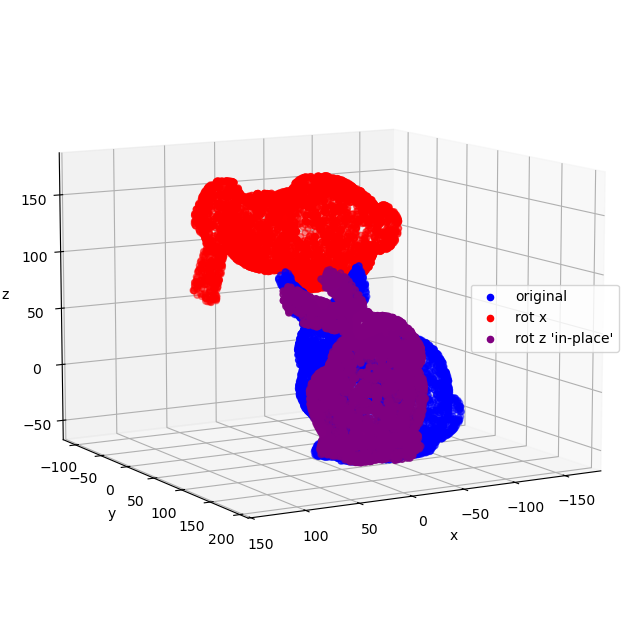

In [3]:
# Rotation around x
theta_x = np.pi/2 # or 90 degrees
R_x = np.array([
    [1., 0., 0.],
    [0., np.cos(theta_x), -np.sin(theta_x)],
    [0., np.sin(theta_x), np.cos(theta_x)]
])
points_rot_x = (R_x @ points.T).T
# Rotation around z "in-place"
theta_z = np.pi/3 # or 120 degrees
R_z = np.array([
    [np.cos(theta_z), -np.sin(theta_z), 0.],
    [np.sin(theta_z), np.cos(theta_z), 0.],
    [0., 0., 1.]
])
points_rot_z = (R_z @ centered_points.T).T + centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_x[:, 0], points_rot_x[:, 1], points_rot_x[:, 2],
           c='red', label="rot x")
ax.scatter(points_rot_z[:, 0], points_rot_z[:, 1], points_rot_z[:, 2],
           c='purple', label="rot z 'in-place'")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

A rotation matrix may also be computed using an arbitrary axis (i.e., different from one of the axes of the main coordinate system). Given a unit vector $u$ (on the axis) and angle $\theta$, the rotation matrix is written:

\begin{equation*}
R_{u}(\theta_u) = 
\begin{pmatrix}
u_{x}^{2}(1-\cos\theta_u)+\cos\theta_u & u_{x}u_{y}(1-\cos\theta_u)-u_{z}\sin\theta_u & u_{x}u_{z}(1-\cos\theta_u)+u_{y}\sin\theta_u \\
u_{x}u_{y}(1-\cos\theta_u)+u_{z}\sin\theta_u & u_{y}^{2}(1-\cos\theta_u)+\cos\theta_u & u_{y}u_{z}(1-\cos\theta_u)-u_{x}\sin\theta_u \\
u_{x}u_{z}(1-\cos\theta_u)-u_{y}\sin\theta_u & u_{y}u_{z}(1-\cos\theta_u)+u_{x}\sin\theta_u & u_{z}^{2}(1-\cos\theta_u)+\cos\theta_u
\end{pmatrix}
\end{equation*}


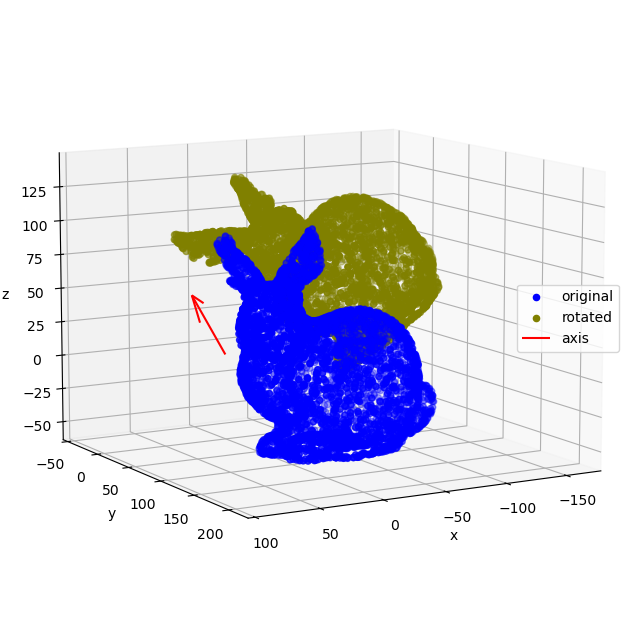

In [4]:
# Rotation around
u = np.array([np.sqrt(3)/3, np.sqrt(3)/3, np.sqrt(3)/3])
u_x, u_y, u_z = u
theta = np.pi/4 # or 45 degrees
c, s = np.cos(theta), np.sin(theta)
R_u = np.array([
    [(u_x**2)*(1-c)+c, u_x*u_y*(1-c)-u_z*s, u_x*u_z*(1-c)+u_y*s],
    [u_x*u_y*(1-c)+u_z*s, (u_y**2)*(1-c)+c, u_y*u_z*(1-c)-u_x*s],
    [u_x*u_z*(1-c)-u_y*s, u_y*u_z*(1-c)+u_x*s, (u_z**2)*(1-c)+c]
])
points_rot_u = (R_u @ points.T).T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_u[:, 0], points_rot_u[:, 1], points_rot_u[:, 2],
           c='olive', label="rotated")
ax.quiver(0., 0., 0., 100.*u_x, 100.*u_y, 100.*u_z,
          color='red', label="axis") # axis of rotation
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

It is then possible to obtain any rotation matrix from the three elemental rotation matrices seen above.

Although commonly used, this approach should be treated with caution. Remember, for example, that matrix multiplication is not commutative ($R_{x}.R_{y} \neq R_{y}.R_{x}$), so order does matter. Consequently, there are many possible rotation sequences (x-y-z, y-z-x, z-x-y, etc.). What's more, each additional rotation may also refer to either the global coordinate system (extrinsic rotation) or to the last rotated coordinate system (intrinsic rotation).

Without going into too much detail, note **there is not a single "good" way of defining a rotation matrix in terms of elemental rotations**. That's why quaternions are often preferred when compacity, efficiency, and numerical stability are important.

Check if rotations R_t1 and R_t2 are the same: False


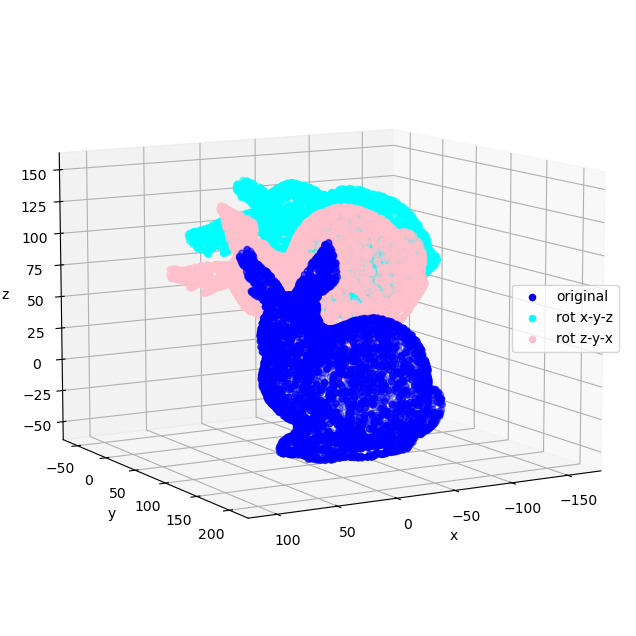

In [5]:
# Rotation around x
theta_x, theta_y, theta_z = np.pi/5, np.pi/6, np.pi/7
R_x = np.array([
    [1., 0., 0.],
    [0., np.cos(theta_x), -np.sin(theta_x)],
    [0., np.sin(theta_x), np.cos(theta_x)]
])
R_y = np.array([
    [np.cos(theta_y), 0., np.sin(theta_y)],
    [0., 1., 0.],
    [-np.sin(theta_y), 0., np.cos(theta_y)]
])
R_z = np.array([
    [np.cos(theta_z), -np.sin(theta_z), 0.],
    [np.sin(theta_z), np.cos(theta_z), 0.],
    [0., 0., 1.]
])
# First sequence of rotations (x-y-z)
R_xyz = R_x @ R_y @ R_z
points_rot_xyz = (R_xyz @ points.T).T
# Second sequence of rotations (z-y-x)
R_zyx = R_z @ R_y @ R_x
points_rot_zyx = (R_zyx @ points.T).T
# Comparison between the two sequences (not the same result)
print("Check if rotations R_t1 and R_t2 are the same:", np.allclose(points_rot_xyz, points_rot_zyx))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_xyz[:, 0], points_rot_xyz[:, 1], points_rot_xyz[:, 2],
           c='cyan', label="rot x-y-z")
ax.scatter(points_rot_zyx[:, 0], points_rot_zyx[:, 1], points_rot_zyx[:, 2],
           c='pink', label="rot z-y-x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

We have seen how to compose $R_t$ given the angles $(\theta_x, \theta_y, \theta_z)$, but the inverse operation is also possible.

Given a rotation matrix and considering (for example) the extrinsic rotation z-y-x (the corresponding angles are often called *yaw*, *pitch*, and *roll* in aeronautics), the equations is written:
\begin{equation*}
\begin{aligned}
R_{t} & = 
\begin{pmatrix}
r_{00} & r_{01} & r_{02} \\
r_{10} & r_{11} & r_{12} \\
r_{20} & r_{21} & r_{22} \\
\end{pmatrix} \\
\\
 & =
\begin{pmatrix}
\cos\theta_y \cos\theta_z & \sin\theta_x \sin\theta_y \cos\theta_z - \cos\theta_x \sin\theta_z & \cos\theta_x \sin\theta_y \cos\theta_z + \sin\theta_x \sin\theta_z \\
\cos\theta_y \sin\theta_z & \sin\theta_x \sin\theta_y \sin\theta_z + \cos\theta_x \cos\theta_z & \cos\theta_x \sin\theta_y \sin\theta_z - \sin\theta_x \cos\theta_z \\
-\sin\theta_y & \sin\theta_x \cos\theta_y & \cos\theta_x \cos\theta_y \\
\end{pmatrix}
\end{aligned}
\end{equation*}

Using the bottom and left (simpler) terms for identification and remembering that $\tan{\theta}= \sin\theta / \cos\theta$ , it is possible to deduce that:
\begin{equation*}
\theta_{x} = arctan2(r_{21}, r_{22}) \quad
\theta_{y} = arctan2(-r_{20}, \sqrt{r^{2}_{21}+r^{2}_{22}}) \quad
\theta_{z} = arctan2(r_{10}, r_{00}) \quad
\end{equation*}

with $arctan2$ being the element-wise arc tangent of the ratio of the two numbers choosing the quadrant correctly.

Note that these angles satisfy the conditions $\theta_x \in [-\pi, \pi], \theta_y \in [-\frac{\pi}{2}, \frac{\pi}{2}], \theta_z \in [-\pi, \pi]$.



In [6]:
r_00, _, _, r_10, _, _, r_20, r_21, r_22 = R_zyx.flatten()
# Compute angles
theta_x_calc = np.arctan2(r_21, r_22)
theta_y_calc = np.arctan2(-r_20, np.sqrt(r_21**2 + r_22**2))
theta_z_calc = np.arctan2(r_10, r_00)
# Compare to initial angles
print("Check if theta_x_calc and theta_x are the same:", np.allclose(theta_x, theta_x_calc))
print("Check if theta_y_calc and theta_y are the same:", np.allclose(theta_y, theta_y_calc))
print("Check if theta_z_calc and theta_z are the same:", np.allclose(theta_z, theta_z_calc))

Check if theta_x_calc and theta_x are the same: True
Check if theta_y_calc and theta_y are the same: True
Check if theta_z_calc and theta_z are the same: True


## Reflections

**A reflection or "mirror" flips the pointcloud in a mirror plane** so that each point is the same distance from the mirror plane as its reflected point.

As for rotations, it is possible to consider reflections in the three planes built from the main coordinate system (i.e., $Oxy$, $Oyz$, and $Ozx$). A reflection in these planes leave the coordinates of each point unchanged except in the direction of their normals (e.g., the normal of the $Oxy$ plane is $y$) where the coordinate is "flipped".
\begin{equation*}
Rf_{x} = 
\begin{pmatrix}
-1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\quad
Rf_{y} = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\quad
Rf_{z} = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -1
\end{pmatrix}
\end{equation*}

In practice, matrix multiplication is once again used to flip each point of the pointcloud (do not forget that some attributes such as normals must also be flipped as well!): 
\begin{equation*}
p' = (Rf.p^{T})^{T}
\end{equation*}

Again, centering the pointcloud first is necessary for an "in-place" mirror operation.

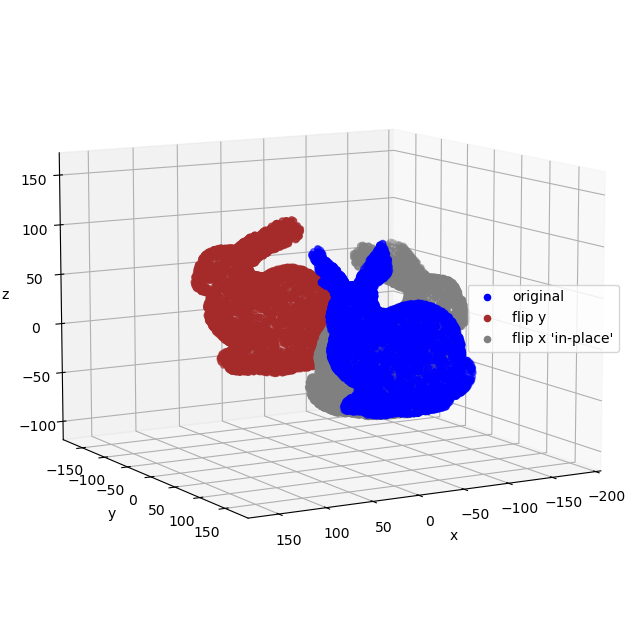

In [7]:
# Flip around y
Rf_y = np.array([
    [1., 0., 0.],
    [0., -1., 0.],
    [0., 0., 1.]
])
points_flip_y = (Rf_y @ points.T).T
# Flip around x "in-place"
Rf_x = np.array([
    [-1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.]
])
points_flip_x = (Rf_x @ centered_points.T).T + centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_flip_y[:, 0], points_flip_y[:, 1], points_flip_y[:, 2],
           c='brown', label="flip y")
ax.scatter(points_flip_x[:, 0], points_flip_x[:, 1], points_flip_x[:, 2],
           c='gray', label="flip x 'in-place'")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

A reflection matrix may also be computed using an arbitrary plane.

A 3D plane $P$ is typically described by its cartesian equation $a.x + b.y + c.z + d = 0$, with $a$, $b$, and $c$ describing its orientation and $d$ its distance to origin. In this case, the plane normal is defined by $n = [a, b, c]$ (generally a unit vector) and any given point $p_i \in P$ verifies $p_i \cdot n = -d$. 

Remembering that a projection matrix on a plane going through the origin ($d = 0$) is given by:
\begin{equation*}
Pr_O = \frac{n^{T} \cdot n}{||n^2||} \iff Pr_O = n^{T} \cdot n \quad \text{for} \quad ||n|| = 1
\end{equation*}

It is possible to deduce that the reflection matrix is:
\begin{equation*}
Rf_O = I - 2 . n^{T} \cdot n =
\begin{pmatrix}
1-2a^2 & -2ab & -2ac \\
-2ab & 1-2b^2 & -2bc \\
-2ac & -2bc & 1-2c^2
\end{pmatrix}
\end{equation*}

(which may be seen as the original points' position subtracted by two times the distance to the plane).

Hence the coordinates of the mirrored points is given by:
\begin{equation*}
p'_O = (Rf_O.p^{T})^{T}
\end{equation*}

If the plane do not goes through the origin, a simple translation is added:
\begin{equation*}
p' = p'_O - 2 . d. n = (I - 2 . n^{T} \cdot n) \cdot p - 2 . d. n
\end{equation*}

Again, thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

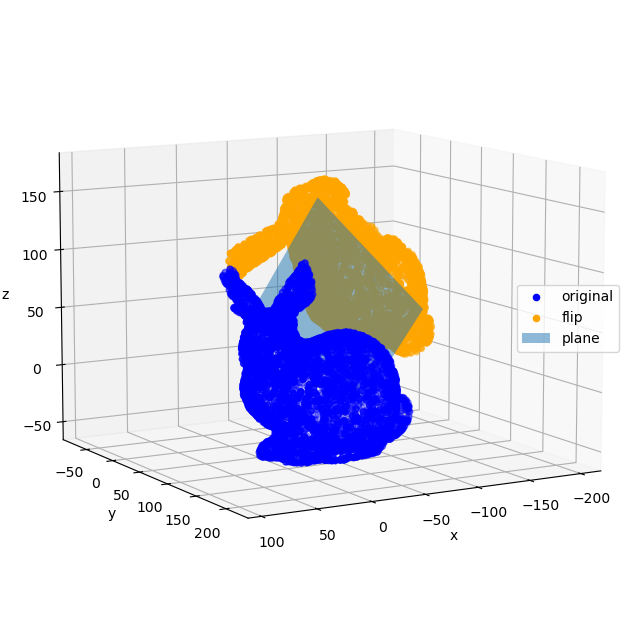

In [8]:
# Plane coordinates
n = np.array([-np.sqrt(3)/3, -np.sqrt(3)/3, np.sqrt(3)/3])
a, b, c = n
d = -10.
# Projection
Rf_O = np.eye(3) - 2 * n.reshape(-1, 1) @ n.reshape(1, -1) # n initial shape is (3,) and the dot product needs to be (3, 1)*(1, 3)
points_flip = (Rf_O @ points.T).T - 2 * d * n

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_flip[:, 0], points_flip[:, 1], points_flip[:, 2],
           c='orange', label="flip")
# plot plane
xx, yy = np.meshgrid(np.linspace(-100, 0, 2), np.linspace(50, 150, 2))
z = -(a*xx + b*yy + d)/c
ax.plot_surface(xx, yy, z, alpha=0.5, label="plane")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

Note that, as for rotations, it is perfectly possible to sequence the reflection operations seen above.

## Scaling

**Scaling or resizing increases or diminishes the dimensions of the pointcloud by a scale factor**.

When the scale factor is the same in all direction, scaling is said to be uniform or isotropic. In practice, the scale factor $s$ is simply used to multiply each point of the pointcloud:
\begin{equation*}
p' = s.p
\end{equation*}

When the scale factor is different in some directions, scaling is said to be non-uniform or anisotropic. Considering the three axes of the main coordinate system, we may deduce the following scaling matrix:
\begin{equation*}
Sc = 
\begin{pmatrix}
s_x & 0 & 0 \\
0 & s_y & 0 \\
0 & 0 & s_z
\end{pmatrix}
\end{equation*}
with $s_x$, $s_y$, and $s_z$ being the scale factors in the $x$, $y$, and $z$ direction respectively.

In practice, matrix multiplication is once again used to scale each point of the pointcloud (do not forget that some attributes such as normals must also be scaled as well!): 
\begin{equation*}
p' = (Sc.p^{T})^{T}
\end{equation*}

Again, centering the pointcloud first is necessary for an "in-place" scaling operation. You can indeed note that the scaled pointcloud "moves away" from the original one if the latter is not centered.


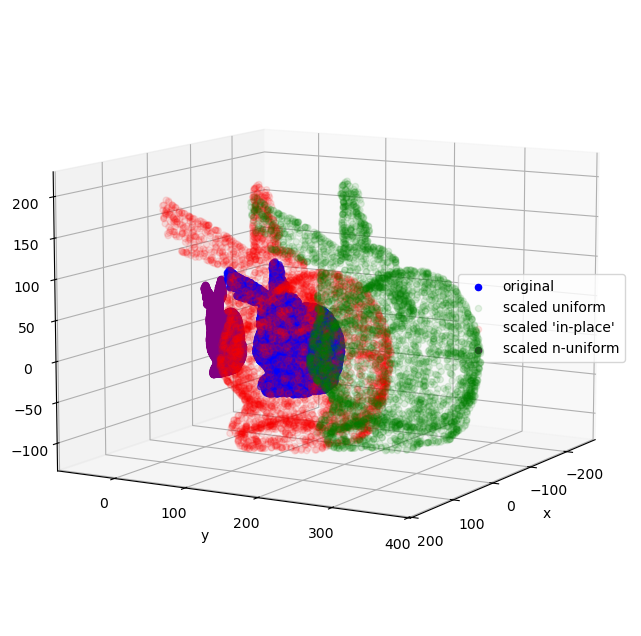

In [9]:
# Uniform scaling
s = 2.
points_u_scaled_1 = s * points
points_u_scaled_2 = s * centered_points + centroid
# Non uniform scaling
Sc = np.array([
    [.5, 0., 0.],
    [0., .2, 0.],
    [0., 0., .75]
])
points_nu_scaled = (Sc @ points.T).T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_u_scaled_1[:, 0], points_u_scaled_1[:, 1], points_u_scaled_1[:, 2],
           c='green', alpha=0.1, label="scaled uniform")
ax.scatter(points_u_scaled_2[:, 0], points_u_scaled_2[:, 1], points_u_scaled_2[:, 2],
           c='red', alpha=0.1, label="scaled 'in-place'")
ax.scatter(points_nu_scaled[:, 0], points_nu_scaled[:, 1], points_nu_scaled[:, 2],
           c='purple', label="scaled n-uniform")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 30)
plt.axis("equal")
plt.show()

## Going further

The latest subsections gave a glimpse of the most commonly found pointcloud transformations (i.e., affine transformations that include translations, rotations, reflections, scaling, and shearing) and how to implement them in a quite painless manner. You may however be starting to realize that this topic is not so simple at all. What's more, some aspects have been left out, such as shearing. A way longer notebook would have been necessary to go through them all in detail.

You may have noticed that **all the discussed transformations may be expressed as a combination of matrix multiplications and vector additions**. That's **because we used Cartesian coordinates**. In computer graphics and computer vision (both fields make extensive use of pointclouds or 3D representations that share some of their properties such as meshes), **these operations are often represented using a matrix multiplication only**, allowing simpler and more efficient processing, **thanks to Homogeneous coordinates**.

In Homogeneous coordinates, transformations are all expresses in the form of a $(4, 4)$ matrix. A first consequence is that the shape of pointcloud is slightly altered, with the addition of a fourth coordinate equal to 1, such as:
\begin{equation*}
p_i = [x_i, y_i, z_i, 1]
\end{equation*}
hence a basic pointcloud shape becomes $(n, 4)$ ($n$ being the total number of points).

With this notation, a translation matrix is written:
\begin{equation*}
\begin{pmatrix}
1 & 0 & 0 & t_x\\
0 & 1 & 0 & t_y\\
0 & 0 & 1 & t_z\\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation*}

Rotations around the main axes are written:
\begin{equation*}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & \cos\theta_x & -\sin\theta_x & 0\\
0 & \sin\theta_x & \cos\theta_x & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\quad
\begin{pmatrix}
\cos\theta_y & 0 & \sin\theta_y & 0\\
0 & 1 & 0 & 0\\
-\sin\theta_y & 0 & \cos\theta_y & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\quad
\begin{pmatrix}
\cos\theta_z & -\sin\theta_z & 0 & 0 \\
\sin\theta_z & \cos\theta_z & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation*}

and so on.

No need to be surprised if you encounter Homogeneous coordinates in more advanced pointcloud processing libraries or software then.

## Wrapping up

You should now have a better grasp of the fundamental spatial transformations applicable to 3D pointclouds, including translations, rotations, reflections, and scaling. These transformations are essential tools to deal with the more advanced processing algorithms that are discussed in the next notebooks.

One key takeaway is that these transformations are implemented quite simply using Numpy (again, vectorization is key to keep the code both readable and efficient). Basic manipulations of pointclouds of up to a few million points in a "reasonable" time should be possible, even with a standard laptop.